In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [2]:
df = pd.read_csv("data/AEP_hourly.csv")

In [3]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [4]:
len(df)

121273

## Data Preparation

In [5]:
# check for dublicate rows
df[df.duplicated(keep=False)]

,Datetime,AEP_MW


In [6]:
# check for duplicate timestamps
df[df.duplicated(subset=['Datetime'], keep=False)]

,Datetime,AEP_MW
82492,2014-11-02 02:00:00,12994.0
82493,2014-11-02 02:00:00,13190.0
91275,2015-11-01 02:00:00,10785.0
91276,2015-11-01 02:00:00,10542.0
99915,2016-11-06 02:00:00,10964.0
99916,2016-11-06 02:00:00,11008.0
108723,2017-11-05 02:00:00,10596.0
108724,2017-11-05 02:00:00,10446.0


In [7]:
df = df.drop_duplicates(subset=['Datetime'])

- since the dublicated readings are not much different from their match, removing them will be fine.

In [8]:
df.isna().sum() 

Datetime    0
AEP_MW      0
dtype: int64

- When checking for missing values in the dataset, no rows were found with explicitly stated null values. However, this does not guarantee that there are no missing data points. Since the data is collected at an hourly rate, it's possible that some hours may be entirely absent from the dataset. Therefore, it's essential to check for missing timestamps to ensure there are no gaps in the hourly sequence.

In [9]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

start_date = df['Datetime'].min()
end_date = df['Datetime'].max()

# Generate a full range of hourly timestamps between the start and end dates
full_range = pd.date_range(start=start_date, end=end_date, freq='h')

# Find any missing timestamps by comparing with the actual timestamps in the data
missing_timestamps = full_range.difference(df['Datetime'])

if missing_timestamps.empty:
    print("No missing hours. The data is continuous.")
else:
    print(f"{len(missing_timestamps)} missing timestamps detected:")
    print(missing_timestamps)

27 missing timestamps detected:
DatetimeIndex(['2004-10-31 02:00:00', '2005-04-03 03:00:00',
               '2005-10-30 02:00:00', '2006-04-02 03:00:00',
               '2006-10-29 02:00:00', '2007-03-11 03:00:00',
               '2007-11-04 02:00:00', '2008-03-09 03:00:00',
               '2008-11-02 02:00:00', '2009-03-08 03:00:00',
               '2009-11-01 02:00:00', '2010-03-14 03:00:00',
               '2010-11-07 02:00:00', '2010-12-10 00:00:00',
               '2011-03-13 03:00:00', '2011-11-06 02:00:00',
               '2012-03-11 03:00:00', '2012-11-04 02:00:00',
               '2012-12-06 04:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2014-03-11 14:00:00', '2015-03-08 03:00:00',
               '2016-03-13 03:00:00', '2017-03-12 03:00:00',
               '2018-03-11 03:00:00'],
              dtype='datetime64[ns]', freq=None)


In [10]:
# Reindex the DataFrame to include the full range of timestamps, filling in missing ones with NaN
df = df.set_index('Datetime').reindex(full_range).rename_axis('Datetime').reset_index()

# Fill missing values using the average of the same hour on other days within the same month
df['hour'] = df['Datetime'].dt.hour
df['month'] = df['Datetime'].dt.month
df['year'] = df['Datetime'].dt.year

# Apply the fill based on average from the same hour and month
df['AEP_MW'] = df.groupby(['year', 'month', 'hour'])['AEP_MW'].transform(
    lambda x: x.fillna(x.mean()//1))

- To fill the missing values, i used time-based interpolation using the average value from the same hour on other days within the same month. I chose a month as electricity consumption can vary by season, so a month seems more reasonable at estimating the missing value without skewing it with consumption patterns. Same thing goes for using the hour.

### Features Engineering

In [11]:
df['Date'] = df['Datetime'].dt.date
df['Hour'] = df['Datetime'].dt.hour

# Creating the pivot table to get one row per day and one column per hour (0-23)
pivot_table = df.pivot_table(index='Date', columns='Hour', values='AEP_MW')

# Rename the columns
pivot_table.columns = [f'Hour_{int(col)}' for col in pivot_table.columns]


In [12]:
pivot_table.head(2)

,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
Date,,,,,,,,,,,,,,,,,,,,,
2004-10-01,NaN,12379.0,11935.0,11692.0,11597.0,11681.0,12280.0,13692.0,14618.0,14903.0,...,15655.0,15739.0,15739.0,15644.0,15353.0,15034.0,15211.0,15349.0,14837.0,14067.0
2004-10-02,13147.0,12260.0,11672.0,11352.0,11177.0,11142.0,11331.0,11866.0,12387.0,13144.0,...,13934.0,13758.0,13579.0,13620.0,13483.0,13379.0,13825.0,14056.0,14015.0,12940.0


In [13]:
pivot_table.tail(2)

,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-02,14125.0,13286.0,12587.0,12296.0,12059.0,12224.0,12781.0,13661.0,14326.0,14834.0,...,18067.0,18534.0,18826.0,18869.0,18562.0,18118.0,17673.0,17303.0,17001.0,15964.0
2018-08-03,14809.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Pivoting the dataframe resulted in null values in the very first and very last day, as the pivotting forced each day to contain the complete 24 hours. The values will be interpolated using the same approach as previous. 

In [14]:
pivot_table = pivot_table.reset_index()

pivot_table['Date'] = pd.to_datetime(pivot_table['Date'])
pivot_table['Year'] = pivot_table['Date'].dt.year
pivot_table['Month'] = pivot_table['Date'].dt.month

pivot_long = pivot_table.set_index(['Year', 'Month', 'Date']).T
pivot_table = pivot_long.apply(lambda row: row.fillna(row.groupby(['Year', 'Month']).transform(lambda x: x.mean()//1)), axis=1)

pivot_table = pivot_table.T.reset_index()
pivot_table.drop(['Year', 'Month'], axis=1, inplace=True)

In [15]:
pivot_table.isna().sum().sum()

0

## Data Normalization

In [16]:
scaler = StandardScaler()
numeric_columns = pivot_table.select_dtypes(include=['float64', 'int64']).columns
pivot_table[numeric_columns] = scaler.fit_transform(pivot_table[numeric_columns])

## Clustering

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

X = pivot_table[numeric_columns] 


# Test for k values from 2 to 5 clusters
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    score = silhouette_score(X, labels)
    print(f'Silhouette Score for {k} clusters: {score}')

Silhouette Score for 2 clusters: 0.4464837230086099
Silhouette Score for 3 clusters: 0.34758374443485296
Silhouette Score for 4 clusters: 0.36628614323898245
Silhouette Score for 5 clusters: 0.3399918018706565


In [18]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

eps_values = [0.1, 0.2, 0.3, 0.4]
min_samples_values = [2, 3, 4, 5]

# Iterate over all combinations of eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X)

        # Count unique labels (excluding noise)
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

        # Calculate silhouette score if more than 1 cluster exists
        if n_clusters > 1:
            score = silhouette_score(X, dbscan_labels)
            print(f"eps={eps}, min_samples={min_samples}: Silhouette Score: {score}")


eps=0.2, min_samples=2: Silhouette Score: -0.5703297176256226
eps=0.3, min_samples=2: Silhouette Score: -0.7107559196970178
eps=0.3, min_samples=3: Silhouette Score: -0.6314315292718181
eps=0.3, min_samples=4: Silhouette Score: -0.34087381567088276
eps=0.3, min_samples=5: Silhouette Score: -0.33919517239543495
eps=0.4, min_samples=2: Silhouette Score: -0.5107777305935446
eps=0.4, min_samples=3: Silhouette Score: -0.6091287528843454
eps=0.4, min_samples=4: Silhouette Score: -0.6060165855040234
eps=0.4, min_samples=5: Silhouette Score: -0.610839752805589


In [19]:
from sklearn.cluster import AgglomerativeClustering


for n in range(2, 6):
    agg_cluster = AgglomerativeClustering(n_clusters=n) # You can adjust n_clusters
    agg_labels = agg_cluster.fit_predict(X)
    
    # Evaluate with silhouette score
    from sklearn.metrics import silhouette_score
    agg_silhouette_score = silhouette_score(X, agg_labels)
    print(f'Agglomerative Clustering Silhouette Score: {agg_silhouette_score}')

Agglomerative Clustering Silhouette Score: 0.42335544500821237
Agglomerative Clustering Silhouette Score: 0.40258581252467723
Agglomerative Clustering Silhouette Score: 0.29979935347779313
Agglomerative Clustering Silhouette Score: 0.2887292295035932


- K-Means with k = 2 produced the best results out of the three algorithms

In [20]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=2, random_state=42)

## Visualization 

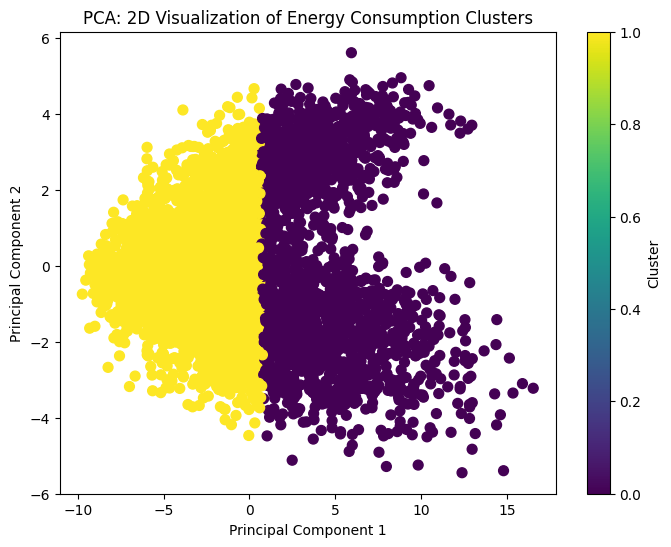

In [21]:
# PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
plt.title('PCA: 2D Visualization of Energy Consumption Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


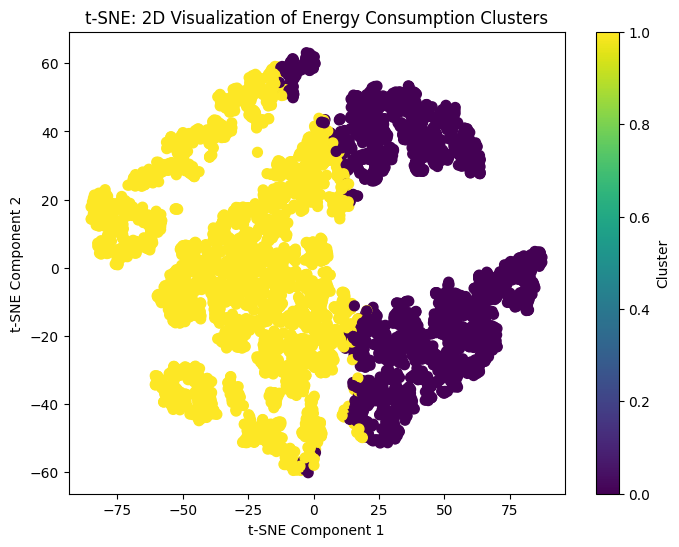

In [22]:
# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
plt.title('t-SNE: 2D Visualization of Energy Consumption Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

## Analysis

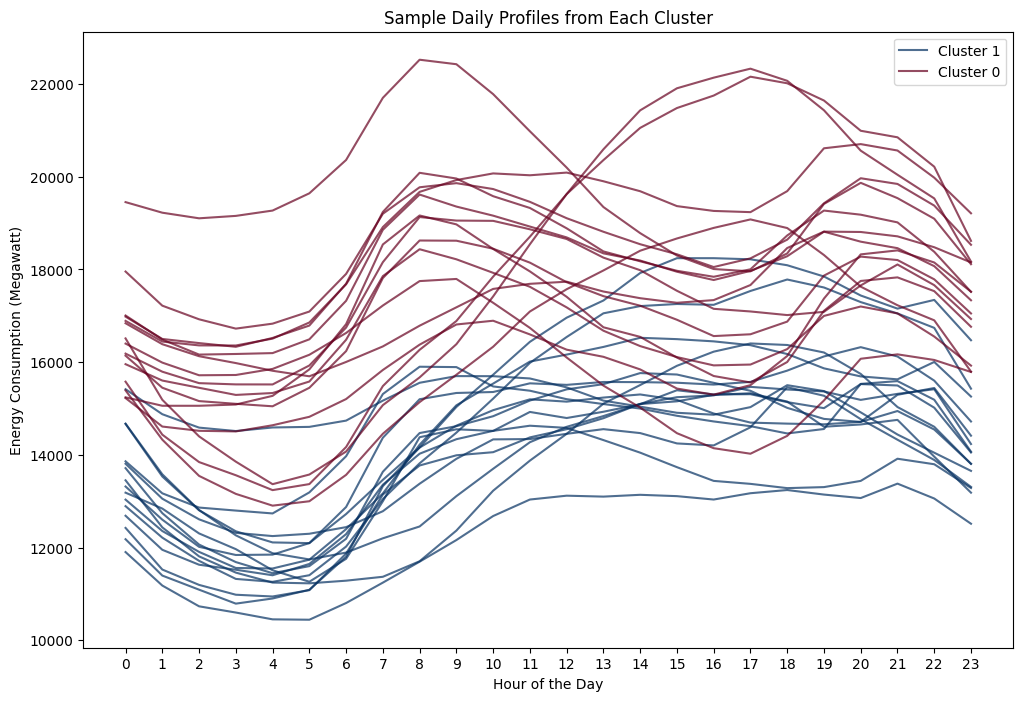

In [23]:
# Add cluster labels to the pivot table
pivot_table['Cluster'] = kmeans.labels_
numeric_columns = pivot_table.select_dtypes(include=['float64', 'int64']).columns

pivot_table[numeric_columns] = scaler.inverse_transform(pivot_table[numeric_columns])


# Plot a few example days from each cluster
clusters = pivot_table['Cluster'].unique()
colors = plt.get_cmap('RdBu', len(clusters))

plt.figure(figsize=(12, 8))

for cluster in clusters:
    sample_days = pivot_table[pivot_table['Cluster'] == cluster].sample(15, random_state=42)
    
    for i, (_, day) in enumerate(sample_days.iterrows()):
        # Only add label for the first line of each cluster
        label = f'Cluster {cluster}' if i == 0 else None
        plt.plot(numeric_columns, day[numeric_columns], alpha=0.7, 
                 label=label, color=colors(cluster))  # Use the color map

plt.title('Sample Daily Profiles from Each Cluster')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Consumption (Megawatt)')
plt.xticks(ticks=range(24), labels=range(24))
plt.legend()
plt.show()

- Plotting random days sampled from each cluster shows that the majority of the days belonging to cluster 1 exhibit higher consumption rate than cluster 0, with some overlapping between them. plotting the average for each hour would make the distinction between the consumption rate more clear.

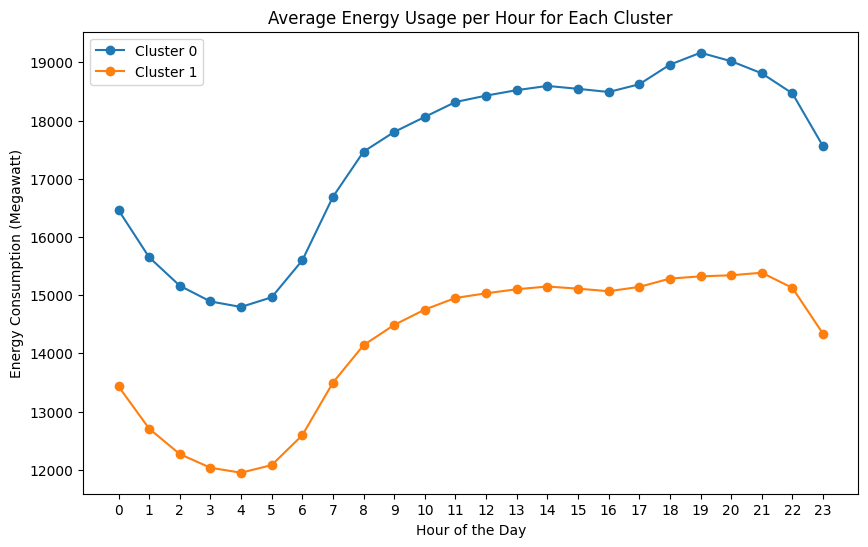

In [24]:
import numpy as np
import pandas as pd

centroids = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids)
centroids_df = pd.DataFrame(centroids, columns=numeric_columns)
plt.figure(figsize=(10, 6))

for i in range(len(centroids_df)):
    plt.plot(centroids_df.columns, centroids_df.iloc[i], marker='o', label=f'Cluster {i}')

plt.title('Average Energy Usage per Hour for Each Cluster')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Consumption (Megawatt)')
plt.xticks(ticks=range(24), labels=range(24))

plt.legend()
plt.show()


- Plotting the average energy usage for each hour shows that cluster 1 represents a slightly lower average consumption, while cluster 0 represents higher consumption. Also, both of them increase and decrease at similar rates, with the consumption increasing during people's active hours (from 7:00 to 00:00).

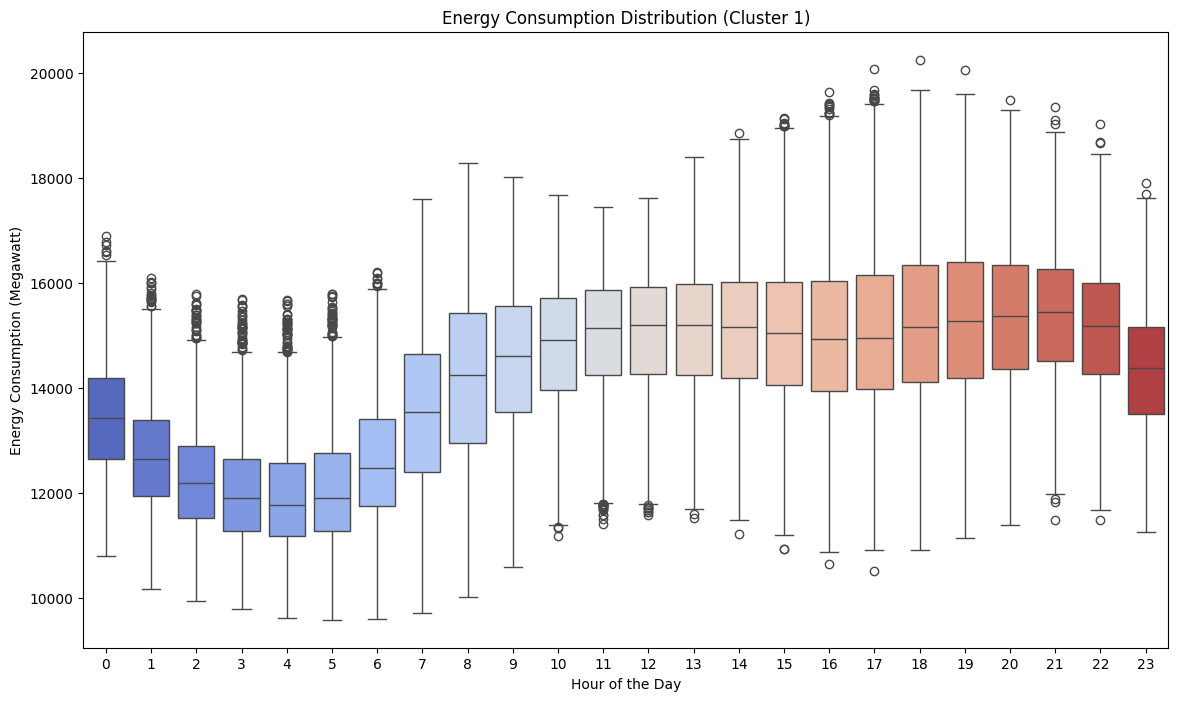

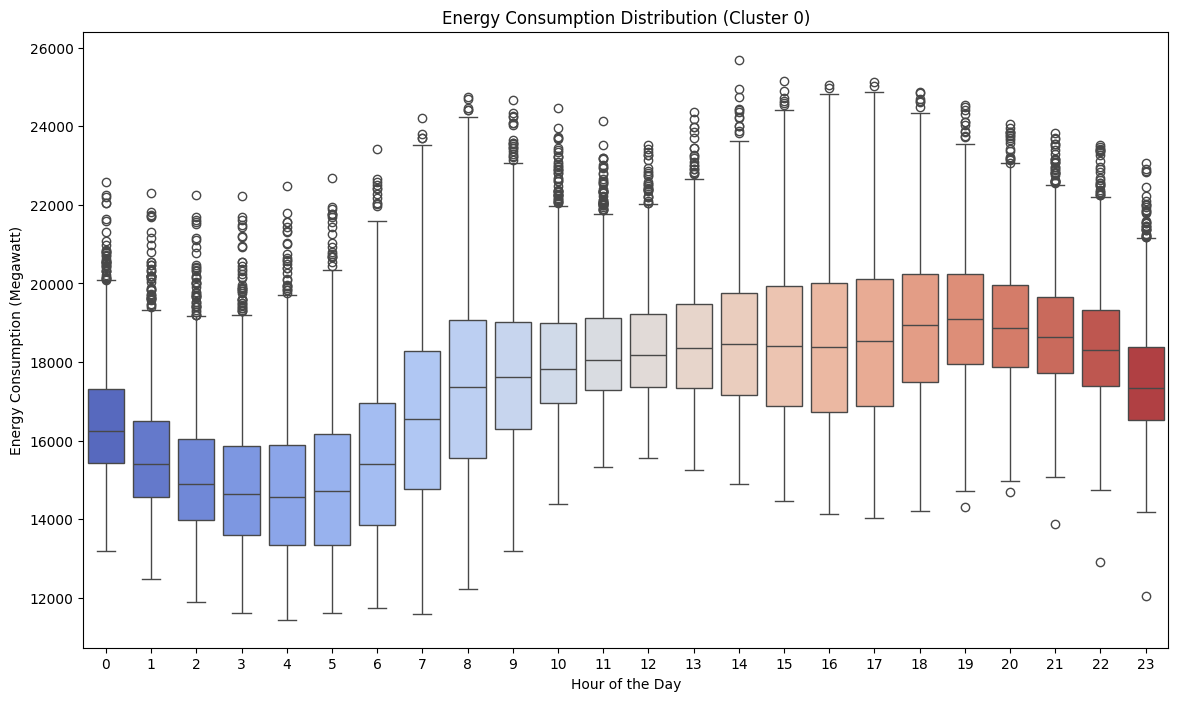

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

hourly_columns = [f'Hour_{i}' for i in range(24)]

# Filter the dataset by each cluster and plot a boxplot for each
for cluster in pivot_table['Cluster'].unique():
    cluster_data = pivot_table[pivot_table['Cluster'] == cluster]
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=cluster_data[hourly_columns], palette='coolwarm')
    plt.title(f'Energy Consumption Distribution (Cluster {cluster})')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Energy Consumption (Megawatt)')
    plt.xticks(ticks=range(24), labels=range(24))
    plt.show()

- Both clusters show similar average trends, with lower energy consumption during early morning hours and peaks in the evening. However, Cluster 1 exhibits more outliers on the lower end from 7:00 to 13:00, indicating instances of lower-than-usual consumption during this period, whereas Cluster 0 has outliers primarily on the higher end, showing occasional spikes in consumption. During peak hours, Cluster 0 demonstrates more variability with a higher number of extreme consumption outliers, suggesting less predictable usage patterns compared to Cluster 1.

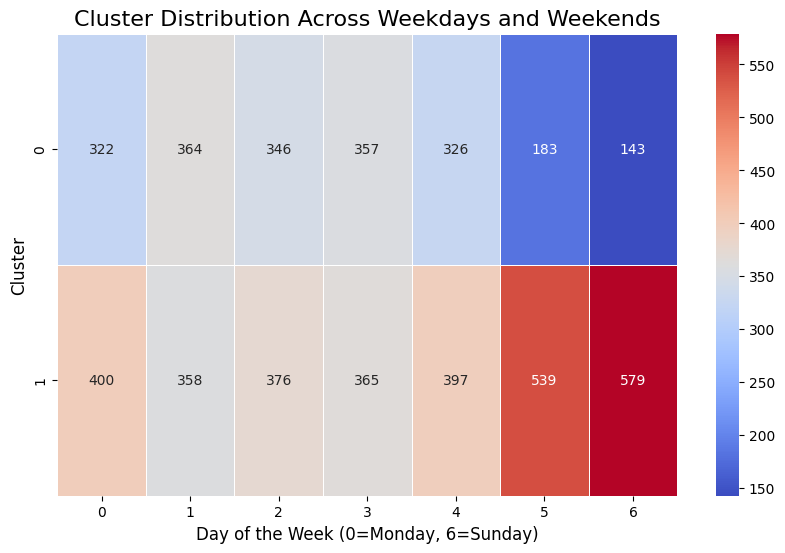

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot_table['DayOfWeek'] = pd.to_datetime(pivot_table['Date']).dt.dayofweek

# Check distribution of clusters across weekdays (0-4) and weekends (5-6)
week_counts = pivot_table.groupby(['Cluster', 'DayOfWeek']).size().unstack()


# Generate a heatmap from the pivot table of week days counts
plt.figure(figsize=(10, 6))
sns.heatmap(week_counts, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5)

plt.title("Cluster Distribution Across Weekdays and Weekends", fontsize=16)
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)", fontsize=12)
plt.ylabel("Cluster", fontsize=12)

# Show the plot
plt.show()


- In the US, the weekend is saturday and sunday, which are encoded as 5 and 6. There is an almost even distribution of points accross both clusters in the weekdays, while there is a significant difference between point counts in clusters in the weekends, where much more points are associated with cluster 1. let's analyze the weekends further.

In [27]:
weekday_data = pivot_table[pivot_table['DayOfWeek'].isin([0, 1, 2, 3, 4])]
weekend_data = pivot_table[pivot_table['DayOfWeek'].isin([5, 6])]

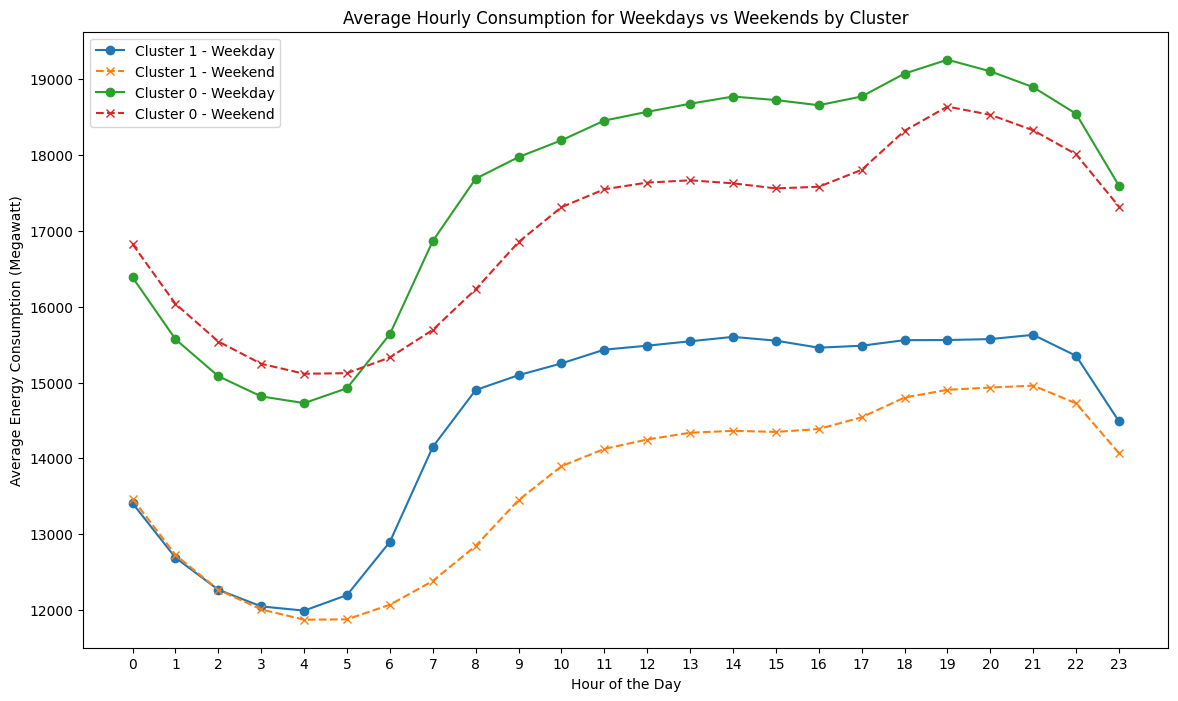

In [28]:
# Plot the average energy consumption for each cluster 
plt.figure(figsize=(14, 8))

for cluster in pivot_table['Cluster'].unique():
    # Calculate mean consumption per hour for weekdays
    mean_weekday = weekday_data[weekday_data['Cluster'] == cluster][hourly_columns].mean()
    # Calculate mean consumption per hour for weekends
    mean_weekend = weekend_data[weekend_data['Cluster'] == cluster][hourly_columns].mean()

    plt.plot(hourly_columns, mean_weekday, label=f'Cluster {cluster} - Weekday', linestyle='-', marker='o')
    plt.plot(hourly_columns, mean_weekend, label=f'Cluster {cluster} - Weekend', linestyle='--', marker='x')

plt.title('Average Hourly Consumption for Weekdays vs Weekends by Cluster')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Energy Consumption (Megawatt)')
plt.xticks(ticks=range(24), labels=range(24))
plt.legend()
plt.show()

- This figure shows that weekends are associated with lower energy consumption than weekdays in both clusters, but the patterns differ. In clusetr 1 the energy use increases sharply on weekdays in the morning, creating a large gap between weekday and weekend consumption. whereas in cluster 0 the gap between weekday and weekend consumption is smaller, with more gradual changes and no sharp increases throughout the day.

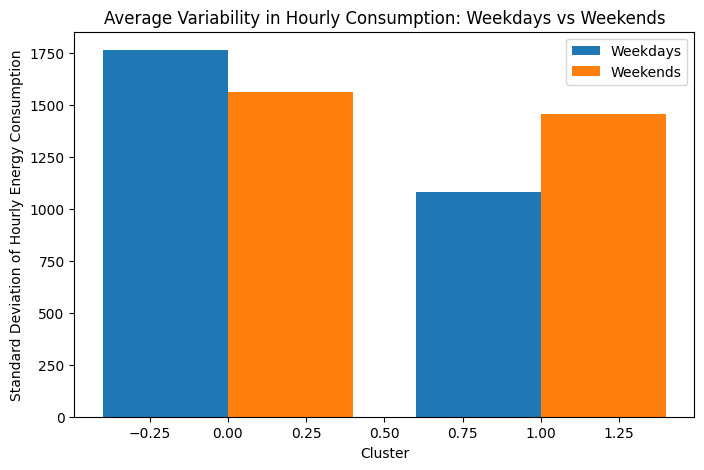

In [29]:
# Calculate the standard deviation of hourly consumption across clusters
weekday_std = weekday_data.groupby('Cluster')[hourly_columns].std().mean(axis=1)
weekend_std = weekend_data.groupby('Cluster')[hourly_columns].std().mean(axis=1)

# Plot variability comparison
plt.figure(figsize=(8, 5))
plt.bar(weekday_std.index - 0.2, weekday_std.values, width=0.4, label='Weekdays')
plt.bar(weekend_std.index + 0.2, weekend_std.values, width=0.4, label='Weekends')

plt.title('Average Variability in Hourly Consumption: Weekdays vs Weekends')
plt.xlabel('Cluster')
plt.ylabel('Standard Deviation of Hourly Energy Consumption')
plt.legend()
plt.show()

- The weekend's energy consumption have much higher variability in cluster 1, which could be explained by irregular activity patterns in the weekends.

## Finidings Summary
- below are the synthesized findings from the previous analysis and visualizations.

| Cluster 1        | Cluster 0        |
|-----------------|-----------------|
| - lower average energy usage for each hour. | - higher average energy usage for each hour. |
| - has outliers on the lower end from 7:00 to 13:00. | - has outliers on the higher end from 7:00 to 13:00. |
| - sharp increase in consumption in the early morning hours in weekdays. | - gradual changes accross the day everyday. |
| - no variability during peak hours from 16:00 to 21:00. | - very high variability during peak hours from 16:00 to 21:00. |
| - contains more weekend data points. | - contains less weekend datapoints. |
| - weekend's energy consumption have much higher variability than weekdays. | - weekend's energy consumption have slightly less variability than weekdays. |



### Cluster 1:
- The lower energy usage could indicate residential areas with lower energy consumption patterns,
- The outliers being on the low end from 7:00 to 13:00 could be explained by an especially lower consumption patterns where people are often away during the morning or early afternoon possibly at work or school.
- Weekdays exhibit a sharp increase in energy use in the early morning hours (5:00 - 8:00) mornings, creating a large gap between weekday and weekend consumption. This may reflect morning routines such as cooking or using electrical appliances before leaving the house.
- The lack of variability during peak hours could suggest a consistent but modest level of energy use, such as homes where appliances are typically turned on during the evening hours (lighting, cooking, etc.), but the energy usage remains stable due to lower demand or smaller-scale activities.
- The higher proportion of weekend data may indicate users or entities that are active during weekends, potentially households with more weekend activities or businesses that operate mainly during weekends.
- The higher variability during weekends could reflect irregular energy usage patterns, such as fluctuating activities (social gatherings, events, or variable activities), which aren't as predictable as weekdays.

### Cluster 0:
- The higher average energy usage, particularly with outliers on the high end, could indicate commercial or industrial buildings, which tend to use more energy.
- The outliers being on the high end from 7:00 to 13:00 could be explained by offices, factories, or retail spaces that experience peaks in energy usage due to equipment, lighting, and heating/cooling systems being turned on in the morning.
- The gap between weekday and weekend energy consumption is smaller, with gradual changes throughout the day. This suggests consistent energy usage patterns, similar to those found in factories or commercial institutions, where operations are steady and less affected by daily fluctuations or sudden spikes in activity.
- High variability in the peak hours may reflect buildings with extended operations, such as restaurants, shops, or commercial facilities, where energy usage can vary significantly depending on the type of entitiy and the level of activity.
- The lower representation of weekend data likely indicates that this cluster contains entities that either don’t operate on weekends (e.g., businesses that close on Saturdays and Sundays) or exhibit much less activity during weekends.
- The slight reduction in variability on weekends may suggest less fluctuation in operations, as the buildings could be operating at a reduced or consistent energy demand level.
### General Insights:
- Cluster 1 seems more aligned with residential patterns or entities that have variable energy consumption based on non-working days (weekends), while Cluster 0 may reflect commercial or institutional buildings where energy usage is consistently higher and more variable during typical business hours.
- The differences between clusters could stem from structural factors like types of buildings, or specific user behaviors during different times of the day or week.